In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import array
from openturns import *
from openturns.viewer import View

RandomGenerator.SetSeed(63)

# Step A - Model specification

In [3]:
dim = 4
model = NumericalMathFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

# Step B - Modelling of the input uncertainty

We first define the marginal distributions

In [4]:
# Young's modulus E: data-based kernel distribution
kernel = KernelSmoothing()
sample = NumericalSample.ImportFromCSVFile("sample_E.csv") * 1e4 # in Pa
dist_E = kernel.build(sample)
# Load F: lognormal
dist_F = LogNormal(3e4, 9e4, 1e-2, LogNormal.MUSIGMA) # in N
# Length L: uniform
dist_L = Uniform(2.5, 2.6) # in m
# Moment of inertia I: beta
dist_I = Beta(2.5, 4, 3.1e-4, 4.5e-4) # in m^4
dist_E.computeQuantile(0.5)

class=NumericalPoint name=Unnamed dimension=1 values=[3.29454e+11]

Then we specify the copula: a Gaussian copula is assumed, with a linear correlation between 'L' and 'I'

In [5]:
R = CorrelationMatrix(dim)
R[2,3] = -.2
myCopula = NormalCopula(NormalCopula.GetCorrelationFromSpearmanCorrelation(R))

Lastly we gather the marginals and the copula to create the joint distribution of the inputs

In [6]:
myDistribution = ComposedDistribution([dist_E, dist_F, dist_L, dist_I], myCopula)

# Step C - Uncertainty propagation based on polynomial chaos

## Construct the polynomial chaos approximation

The types of 1D polynomial families are defined

In [7]:
polyColl = PolynomialFamilyCollection(dim)
polyColl[0] = StandardDistributionPolynomialFactory(dist_E)
polyColl[1] = LaguerreFactory() # beware of ad-hoc polynomials with the lognormal distribution
polyColl[2] = StandardDistributionPolynomialFactory(dist_L)
polyColl[3] = StandardDistributionPolynomialFactory(dist_I)

Define the strategy for enumerating the elements of the multivariate tensorized basis

In [8]:
enumerateFunction = EnumerateFunction(dim)

Determine the number of elements to be retained in the chaos series

In [9]:
p = 4 # total degree
P = enumerateFunction.getStrataCumulatedCardinal(p) # number of chaos terms

Define the multivariate basis

In [10]:
multivariateBasis = OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

Specify the strategy for computing the chaos coefficients: sparse least squares (based on Least Angle Regression)

In [11]:
basisSequenceFactory = LAR()
fittingAlgorithm = CorrectedLeaveOneOut()
approximationAlgorithm = LeastSquaresMetaModelSelectionFactory(basisSequenceFactory, fittingAlgorithm)
N = 600 # size of the experimental design
evalStrategy = LeastSquaresStrategy(MonteCarloExperiment(N), approximationAlgorithm) # Monte Carlo design
truncatureBasisStrategy = FixedStrategy(multivariateBasis, P)

Construct the chaos metamodel

In [12]:
polynomialChaosAlgorithm = FunctionalChaosAlgorithm(model, myDistribution, truncatureBasisStrategy, evalStrategy)
polynomialChaosAlgorithm.run()

Get the result

In [13]:
result = polynomialChaosAlgorithm.getResult()
metamodel = result.getMetaModel()
chaosRV = FunctionalChaosRandomVector(result)

## Validate the metamodel

Generate a validation sample (different from the training sample)

In [14]:
n_valid = 500
inputSample = myDistribution.getSample(n_valid)
outputSample = model(inputSample)

Get the corresponding chaos-based predictions

In [15]:
outputChaosSample = metamodel(inputSample)

Compute the relative mean-square accuracy (so-called Q2 coefficient)

In [16]:
residuals = outputSample - outputChaosSample
Q2 = 1. - residuals.computeVariance()[0] / outputSample.computeVariance()[0]
print("Q2 coefficient (relative accuracy): %.4f" % Q2)

Q2 coefficient (relative accuracy): 0.9997


Plot the actual vs the predicted outputs

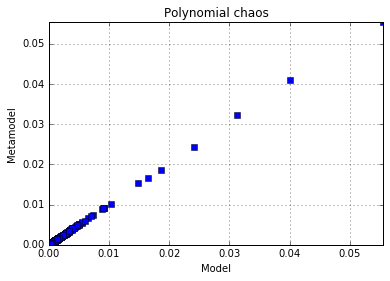

In [17]:
mixedSample = NumericalSample(n_valid, 2)
mixedSample[:,0], mixedSample[:,1] = outputChaosSample, outputSample
pointCloud = Cloud(mixedSample, "blue", "fsquare", "")
graphCloud = Graph("Polynomial chaos", "Model", "Metamodel", True, "topleft")
graphCloud.add(pointCloud)
View(graphCloud).show()

## Post-processing of the chaos expansion

Computation of the output mean and standard deviation from the chaos coefficients

In [18]:
print("Mean: %f" % chaosRV.getMean()[0])
print("Standard deviation: %f" % sqrt(chaosRV.getCovariance()[0,0]))

Mean: 0.001377
Standard deviation: 0.004043


Draw histogram

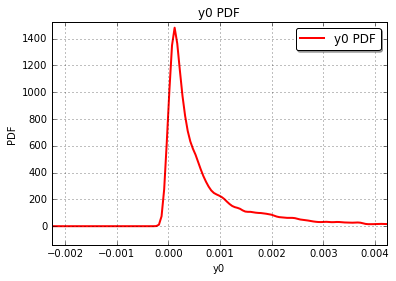

In [19]:
inputBigSample = myDistribution.getSample(10000)
outputBigsample = model(inputBigSample)
kernel2 = KernelSmoothing()
fittedDist = kernel2.build(outputBigsample)
graph = fittedDist.drawPDF()
View(graph).show()

Compute the sensitivity indices

In [20]:
# Main-effects
for i, Xi in enumerate(["E", "F", "L", "I"]):
    sobolIndex = chaosRV.getSobolIndex(i)
    print("Sensitivity to "+Xi+": %f" %sobolIndex)

# Total indices
for i, Xi in enumerate(["E", "F", "L", "I"]):
    sobolTotalIndex = chaosRV.getSobolTotalIndex(i)
    print("Total sensitivity to "+Xi+": %f" %sobolTotalIndex)

Sensitivity to E: 0.001828
Sensitivity to F: 0.978473
Sensitivity to L: 0.000261
Sensitivity to I: 0.000721
Total sensitivity to E: 0.014834
Total sensitivity to F: 0.997183
Total sensitivity to L: 0.002186
Total sensitivity to I: 0.004555


Reliability analysis with a maximal admissible deflection equal to 3 cm 

In [21]:
N = int(1e5)
th = 0.03 # in m
inputVeryBigSample = myDistribution.getSample(N)
outputVeryBigsample = model(inputVeryBigSample)
output_arr = array(outputVeryBigsample).ravel()
Pf = len(np.where(output_arr > th)[0]) / float(N)
print("Estimated probability of failure: %.4e" % Pf)

Estimated probability of failure: 2.3500e-03
